In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.8 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
vocab_size = tokenizer.vocab_size


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [5]:
dataset = load_dataset('daily_dialog')

def format_dialogue(dialogue):
    formatted = []
    for i, utterance in enumerate(dialogue):
        speaker = "User: " if i % 2 == 0 else "Assistant: "
        formatted.append(speaker + utterance)
    return "\n".join(formatted)

train_dialogues = [format_dialogue(d['dialog']) for d in dataset['train']]
val_dialogues = [format_dialogue(d['dialog']) for d in dataset['validation']]
test_dialogues = [format_dialogue(d['dialog']) for d in dataset['test']]

train_tokenized = [tokenizer(d, max_length=512, truncation=True, return_tensors='pt')['input_ids'][0]
                   for d in train_dialogues]
val_tokenized = [tokenizer(d, max_length=512, truncation=True, return_tensors='pt')['input_ids'][0]
                 for d in val_dialogues]
test_tokenized = [tokenizer(d, max_length=512, truncation=True, return_tensors='pt')['input_ids'][0]
                  for d in test_dialogues]

README.md:   0%|          | 0.00/7.27k [00:00<?, ?B/s]

daily_dialog.py:   0%|          | 0.00/4.85k [00:00<?, ?B/s]

The repository for daily_dialog contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/daily_dialog.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/11118 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
class DialogueDataset(Dataset):
    def __init__(self, tokenized_sequences):
        self.sequences = tokenized_sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx]

def collate_fn(batch):
    lengths = [len(seq) for seq in batch]
    max_len = max(lengths)
    padded_seqs = torch.full((len(batch), max_len), tokenizer.pad_token_id, dtype=torch.long)
    for i, seq in enumerate(batch):
        padded_seqs[i, :len(seq)] = seq
    padding_mask = padded_seqs == tokenizer.pad_token_id
    return padded_seqs, padding_mask

In [19]:
train_dataset = DialogueDataset(train_tokenized)
val_dataset = DialogueDataset(val_tokenized)
test_dataset = DialogueDataset(test_tokenized)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [14]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super().__init__()
        assert hidden_size % num_heads == 0, "hidden_size must be divisible by num_heads"
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads

        self.query = nn.Linear(hidden_size, hidden_size)
        self.key = nn.Linear(hidden_size, hidden_size)
        self.value = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, hidden_size)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)

    def forward(self, x, mask=None, padding_mask=None):
        batch_size, seq_len, _ = x.size()

        q = self.query(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.key(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.value(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / self.scale

        if mask is not None:
            scores = scores.masked_fill(mask == 1, -1e4)  # Changed from -1e9 to -1e4 for FP16 compatibility
        if padding_mask is not None:
            padding_mask = padding_mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(padding_mask, -1e4)  # Changed from -1e9 to -1e4

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_size)
        out = self.out(out)
        return out

class TransformerLayer(nn.Module):
    def __init__(self, hidden_size, num_heads, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(hidden_size, num_heads, dropout)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_size, 4 * hidden_size),
            nn.ReLU(),
            nn.Linear(4 * hidden_size, hidden_size),
            nn.Dropout(dropout)
        )
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None, padding_mask=None):
        x = self.ln1(x)
        attn_out = self.attn(x, mask, padding_mask)
        x = x + self.dropout(attn_out)

        x = self.ln2(x)
        ffn_out = self.ffn(x)
        x = x + self.dropout(ffn_out)
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=512, num_layers=6, num_heads=8, dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_embedding = nn.Embedding(512, hidden_size)
        self.layers = nn.ModuleList([
            TransformerLayer(hidden_size, num_heads, dropout) for _ in range(num_layers)
        ])
        self.final_ln = nn.LayerNorm(hidden_size)
        self.head = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, padding_mask=None):
        batch_size, seq_len = input_ids.size()
        positions = torch.arange(0, seq_len, device=input_ids.device).unsqueeze(0).expand_as(input_ids)
        x = self.token_embedding(input_ids) + self.pos_embedding(positions)
        x = self.dropout(x)

        causal_mask = torch.triu(torch.ones(seq_len, seq_len, device=input_ids.device), diagonal=1).bool()

        for layer in self.layers:
            x = layer(x, causal_mask, padding_mask)

        x = self.final_ln(x)
        logits = self.head(x)
        return logits

In [22]:
model = TransformerModel(vocab_size=vocab_size, hidden_size=512, num_layers=12, num_heads=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
scaler = torch.cuda.amp.GradScaler()


<ipython-input-22-4f99a954e278>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [16]:
def train_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss, total_acc = 0, 0
    for input_ids, padding_mask in tqdm(loader, desc="Training"):
        input_ids, padding_mask = input_ids.to(device), padding_mask.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            logits = model(input_ids, padding_mask)
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = input_ids[:, 1:].contiguous()
            loss = loss_fn(shift_logits.view(-1, vocab_size), shift_labels.view(-1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        preds = shift_logits.argmax(dim=-1)
        mask = shift_labels != tokenizer.pad_token_id
        correct = (preds == shift_labels) & mask
        acc = correct.sum().float() / mask.sum().float()
        total_loss += loss.item()
        total_acc += acc.item()
    return total_loss / len(loader), total_acc / len(loader)

In [17]:
def evaluate(model, loader):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for input_ids, padding_mask in tqdm(loader, desc="Evaluating"):
            input_ids, padding_mask = input_ids.to(device), padding_mask.to(device)
            with torch.cuda.amp.autocast():
                logits = model(input_ids, padding_mask)
                shift_logits = logits[:, :-1, :].contiguous()
                shift_labels = input_ids[:, 1:].contiguous()
                loss = loss_fn(shift_logits.view(-1, vocab_size), shift_labels.view(-1))
            preds = shift_logits.argmax(dim=-1)
            mask = shift_labels != tokenizer.pad_token_id
            correct = (preds == shift_labels) & mask
            acc = correct.sum().float() / mask.sum().float()
            total_loss += loss.item()
            total_acc += acc.item()
    return total_loss / len(loader), total_acc / len(loader)


In [23]:
num_epochs = 15
train_losses, val_losses, train_accs, val_accs = [], [], [], []
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scaler)
    val_loss, val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, "
          f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

Training:   0%|          | 0/2780 [00:00<?, ?it/s]<ipython-input-16-843ccfe83f3b>:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.82it/s]


Epoch 1: Train Loss=3.8517, Val Loss=3.3843, Train Acc=0.3954, Val Acc=0.4352


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 33.09it/s]


Epoch 2: Train Loss=3.2525, Val Loss=3.1230, Train Acc=0.4422, Val Acc=0.4592


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.79it/s]


Epoch 3: Train Loss=3.0018, Val Loss=2.9735, Train Acc=0.4625, Val Acc=0.4720


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.89it/s]


Epoch 4: Train Loss=2.8032, Val Loss=2.8681, Train Acc=0.4785, Val Acc=0.4824


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.89it/s]


Epoch 5: Train Loss=2.6150, Val Loss=2.7960, Train Acc=0.4955, Val Acc=0.4911


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 33.21it/s]


Epoch 6: Train Loss=2.4421, Val Loss=2.7419, Train Acc=0.5134, Val Acc=0.4964


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.63it/s]


Epoch 7: Train Loss=2.2636, Val Loss=2.7069, Train Acc=0.5348, Val Acc=0.5032


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 33.13it/s]


Epoch 8: Train Loss=2.1003, Val Loss=2.6933, Train Acc=0.5562, Val Acc=0.5092


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.82it/s]


Epoch 9: Train Loss=1.9392, Val Loss=2.6906, Train Acc=0.5796, Val Acc=0.5128


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.73it/s]


Epoch 10: Train Loss=1.7924, Val Loss=2.6970, Train Acc=0.6020, Val Acc=0.5164


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.52it/s]


Epoch 11: Train Loss=1.6542, Val Loss=2.7199, Train Acc=0.6248, Val Acc=0.5192


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.92it/s]


Epoch 12: Train Loss=1.5255, Val Loss=2.7333, Train Acc=0.6467, Val Acc=0.5254


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.44it/s]


Epoch 13: Train Loss=1.4089, Val Loss=2.7641, Train Acc=0.6675, Val Acc=0.5282


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.29it/s]


Epoch 14: Train Loss=1.3018, Val Loss=2.8124, Train Acc=0.6870, Val Acc=0.5302


Evaluating: 100%|██████████| 250/250 [00:07<00:00, 32.91it/s]

Epoch 15: Train Loss=1.2087, Val Loss=2.8385, Train Acc=0.7042, Val Acc=0.5348


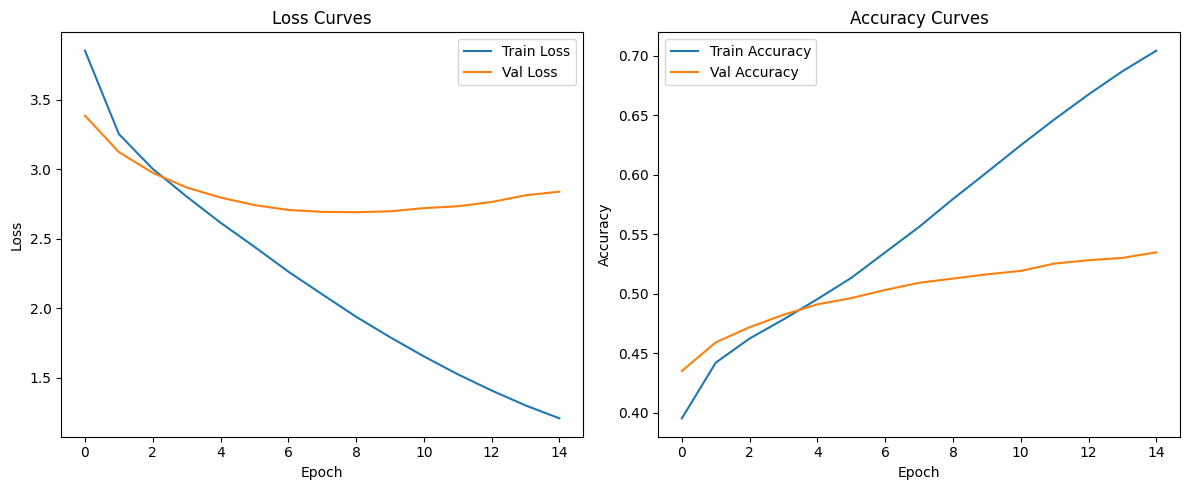

In [24]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')
plt.tight_layout()
plt.show()

In [33]:
def generate_text(model, prompt, max_new_tokens=50):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
    generated_ids = input_ids
    with torch.no_grad():
        for _ in range(max_new_tokens):
            logits = model(generated_ids, padding_mask=None)
            next_token = torch.argmax(logits[:, -1, :], dim=-1).unsqueeze(0)
            generated_ids = torch.cat([generated_ids, next_token], dim=1)
            # Check if the last generated token is a newline
            if tokenizer.decode(next_token.item()) == '\n':
                break
    response = tokenizer.decode(generated_ids[0, len(input_ids[0]):])
    return response.strip()  # Remove trailing whitespace or newlines

# Test
test_loss, test_acc = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
prompt = "User: How was your day?\nAssistant:"
response = generate_text(model, prompt)
print(f"Prompt: {prompt}")
print(f"Response: {response}")

Evaluating:   0%|          | 0/250 [00:00<?, ?it/s]<ipython-input-17-1576575ec1a4>:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Evaluating: 100%|██████████| 250/250 [00:08<00:00, 30.62it/s]


Test Loss: 2.8344, Test Accuracy: 0.5368
Prompt: User: How was your day?
Assistant:
Response: It was so exciting .


In [37]:
model_path = "Conv_GPT.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")
torch.save(model, "Conv_GPT_full.pth")

Model saved to Conv_GPT.pth
